# Student T mixture models

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import jax

import studenttmixture
import matplotlib.pyplot as plt
import sklearn.mixture
import numpy as np
import tqdm
import itertools
import scipy
import scipy.sparse.csgraph
import jax.random as jrandom

# own code
import corc.datasets2d
import corc.graph_metrics
# import corc.datasets_refactor as datasets2d
# import corc.jax_neb as jax_neb
import corc.tmm_plots as tmm_plots

In [8]:
datasets = corc.datasets2d.DATASETS
print(f"there are {len(datasets)} datasets")

dataset_name = 'Clusterlab7'
data_X, data_y = datasets[dataset_name]()
print(f'current dataset has {len(set(data_y.tolist()))} classes')

there are 18 datasets
current dataset has 5 classes


In [ ]:
mixture_model = studenttmixture.EMStudentMixture(
    n_components=2,
    tol=1e-5, # default
    reg_covar=1e-4, # default: 1e-6
    max_iter=1000, # default
    df=1, #default: 4
    fixed_df=True,
    random_state=42,
    init_type="k++",
)

# old stuff

In [28]:
import jax
jax.print_environment_info()

jax:    0.4.31
jaxlib: 0.4.31
numpy:  1.26.4
python: 3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1
platform: uname_result(system='Darwin', node='martin-mon.cidas.uni-goettingen.de', release='23.6.0', version='Darwin Kernel Version 23.6.0: Mon Jul 29 21:16:46 PDT 2024; root:xnu-10063.141.2~1/RELEASE_ARM64_T8112', machine='arm64')



In [29]:
# data loading
key = jrandom.PRNGKey(0)
data_X, data_y = datasets2d.Clusterlab10().sample(key, 300) 
data_X = np.array(data_X, dtype=np.float64)

In [31]:
# Training
n_components = 6
tmm = studenttmixture.EMStudentMixture(n_components=n_components, fixed_df=True, df=1.0, init_type="k++", random_state=42)
tmm.fit(data_X)
gmm = sklearn.mixture.GaussianMixture(n_components=n_components, n_init=5, random_state=11)
gmm.fit(data_X)
print("Trained GMM and TMM.")

Trained GMM and TMM.


In [41]:
np.sort(tmm.location, axis=0)

array([[-16.42299952, -16.1690632 ],
       [ -8.15106046, -14.36762151],
       [ -6.97338555,  -0.09682173],
       [  4.51097169,   0.16244745],
       [  4.69280242,   7.52633147],
       [  8.2547667 ,  11.67558919]])

In [42]:
np.sort(gmm.means_, axis=0)

array([[-16.30988667, -15.69422457],
       [ -8.53797772, -14.52277419],
       [ -6.99442304,   0.14448688],
       [  4.63585642,   0.21552326],
       [  4.66574616,   7.63811437],
       [  8.55010595,  11.61357426]])

In [5]:
# jax_t_probs = jax_neb.tmm_jax(x=XY.reshape(-1,2), means=stm.location, scales=np.transpose(stm.scale, (2,0,1)), weights=stm.mix_weights).reshape(128,128)
# 
# print(f"Difference between jax and other implementation: {np.max(np.abs(jax_t_probs - tmm_probs)):.2}")

# Compute Nudged Elastic Bands using JAX

In [44]:
adjacency = np.zeros((n_components,n_components)) # will hold the scores, i.e. the minimum value encountered on a path
paths = dict() # the bent path positions from one center to another
temps = dict() # "procentual" values of the path (used for plotting logprob against distance)
logprobs = dict() # actual values at path positions

for i, j in tqdm.tqdm(itertools.combinations(range(n_components), r=2), total=n_components * (n_components - 1) // 2):
        # compute nudged elastic band
        path_positions, temperatures, interpolation_probs = jax_neb.compute_interpolation(i, j, means=tmm.location, covs=np.transpose(tmm.scale, (2,0,1)), weights=tmm.mix_weights, iterations=500)
        paths[(i,j)] = path_positions
        temps[(i,j)] = temperatures
        logprobs[(i,j)] = interpolation_probs
        
        # evaluate score of elastic band (minimum value along the path)
        adjacency[i,j] = min(interpolation_probs)      

100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


In [7]:
adjacency

array([[ 0.        , -9.04256248, -8.81196117, -9.32542896, -8.72144413,
        -8.75174236],
       [ 0.        ,  0.        , -8.95402527, -9.25889301, -9.19715309,
        -8.97471714],
       [ 0.        ,  0.        ,  0.        , -9.06714725, -9.49351692,
        -7.36814165],
       [ 0.        ,  0.        ,  0.        ,  0.        , -9.1186142 ,
        -9.19600201],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -9.06549358],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [50]:
type(tmm)

studenttmixture.em_student_mixture.EMStudentMixture

In [51]:
type(gmm)

sklearn.mixture._gaussian_mixture.GaussianMixture

In [63]:
isinstance(gmm, sklearn.mixture.GaussianMixture)

True

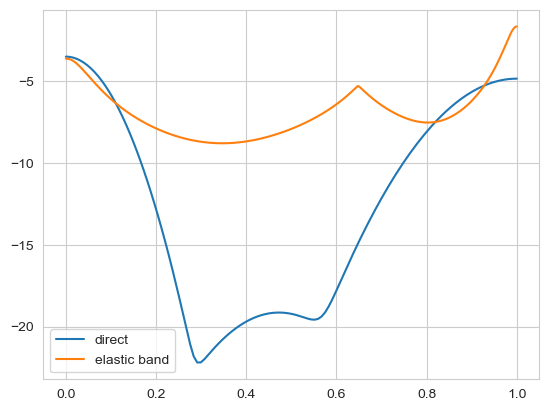

In [54]:
tmm_plots.plot_logprob_lines(gmm, 0, 2, temps, logprobs)

even though the direct line is not far off in this example, the distance widens with more training iterations for NEB, especially when there are "detours" that allow the probability to stay high all the time

# Use MST to compute "real" shortest path between any pair
For "neighbors" the NEB computation is great and converges fast, but whenever the endpoints are far from each other and cross very "low" areas, convergence becomes slow.
Since we are only interested in how "deep" (improbable) we need to go, we can use the MST to find the optimal detours via other density modes.

In [10]:
def compute_mst_distances(adjacency):
    mst = -scipy.sparse.csgraph.minimum_spanning_tree(-adjacency)
    num_nodes = adjacency.shape[0]

    node_array, predecessors = scipy.sparse.csgraph.breadth_first_order(mst, 0, directed=False, return_predecessors=True)

    # initialize distance matrix, -'inf' is neutral  
    distances = np.ones_like(adjacency) * -float('inf')

    # self-loops
    for i in range(num_nodes):
        distances[i][i] = float('inf')
        
    # insert values
    mst = mst.tocoo()
    for u, v, weight in zip(mst.row, mst.col, mst.data):
        distances[u][v] = distances[v][u] = weight
        
    marked = np.zeros(adjacency.shape[0])
    for node in node_array:
        for other_node in range(num_nodes):
            if marked[other_node]:
                # distance is either "direct" or using the parent information
                direct_dist = distances[node][other_node] # not touched before, possibly -inf
                indirect_dist = min(distances[node][predecessors[node]], distances[predecessors[node]][other_node]) # the latter is already computed and the first has a value
                # assign to both directions
                distances[node][other_node] = distances[other_node][node] = max(direct_dist,indirect_dist)
        
        marked[node] = 1
    
    # reset self-loops
    for i in range(num_nodes):
        distances[i,i] = 0
    
    return distances

In [11]:
distances = compute_mst_distances(adjacency)
distances

array([[ 0.        , -8.95402527, -8.75174236, -9.06714725, -8.72144413,
        -8.75174236],
       [-8.95402527,  0.        , -8.95402527, -9.06714725, -8.95402527,
        -8.95402527],
       [-8.75174236, -8.95402527,  0.        , -9.06714725, -8.75174236,
        -7.36814165],
       [-9.06714725, -9.06714725, -9.06714725,  0.        , -9.06714725,
        -9.06714725],
       [-8.72144413, -8.95402527, -8.75174236, -9.06714725,  0.        ,
        -8.75174236],
       [-8.75174236, -8.95402527, -7.36814165, -9.06714725, -8.75174236,
         0.        ]])

In [12]:
adjacency

array([[ 0.        , -9.04256248, -8.81196117, -9.32542896, -8.72144413,
        -8.75174236],
       [ 0.        ,  0.        , -8.95402527, -9.25889301, -9.19715309,
        -8.97471714],
       [ 0.        ,  0.        ,  0.        , -9.06714725, -9.49351692,
        -7.36814165],
       [ 0.        ,  0.        ,  0.        ,  0.        , -9.1186142 ,
        -9.19600201],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -9.06549358],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [13]:
print(f"Using MST instead of direct calculation made a difference of {np.max(np.abs(adjacency - distances)):.4}")

Using MST instead of direct calculation made a difference of 9.067


### plotting (all pairs and MST pairs only)

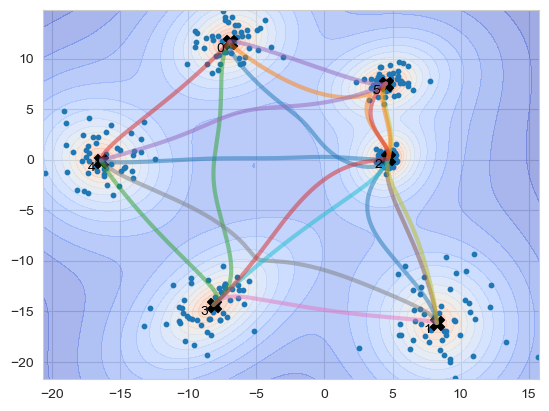

In [23]:
tmm_plots.plot_field(data_X, tmm, paths=paths)

In [24]:
raw_adjacency = adjacency
mst = -scipy.sparse.csgraph.minimum_spanning_tree(-raw_adjacency)

row,col = mst.nonzero()
mst_selection = zip(row, col)

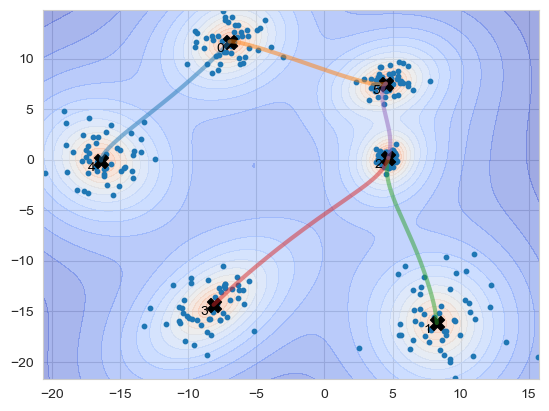

In [25]:
tmm_plots.plot_field(data_X, tmm, paths=paths, selection=mst_selection)